In [623]:
# from sandbox.celine_knowledge_graph import *
# from sandbox.spacy_experiments import *
# from sandbox.neuralcoref_experiments import *
# from bert_embedding import BertEmbedding

In [416]:
import sys
import spacy
import neuralcoref
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load("en_core_web_sm")
neuralcoref.add_to_pipe(nlp)

In [417]:
def clean_src(s):
    s = s.split()
    # remove everything from "-lrb-" to "-rrb-"
    s2 = []
    in_paren = False
    for ixw, w in enumerate(s):
        if(w=="-lrb-"):
            in_paren=True
        elif(w=='-rrb-'):
            in_paren=False
        elif(w=="-lsb-" or w=="-rsb-"):
            continue
        elif(len(w) > 1 and w[0] == '\''):
            s2[-1] = s2[-1]+w
        elif not in_paren and not (w == '<t>' or w == '</t>'):
            s2.append(w)
    return ' '.join(s2)

def clean_gen(s):
    s = s.split()
    # remove everything from "-lrb-" to "-rrb-"
    s2 = []
    in_paren = False
    for w in s:
        if(w=="-lrb-"):
            in_paren=True
        elif(w=='-rrb-'):
            in_paren=False
        elif(w=="-lsb-" or w=="-rsb-"):
            continue
        elif(len(w) > 1 and w[0] == '\''):
            s2[-1] = s2[-1]+w
        elif not in_paren and not(w == '<t>' or w == '</t>'):
            s2.append(w)
    return ' '.join(s2)

In [638]:
class KnowledgeGraph:
    
    def __init__(self):
        self.relations = list()
        self.noun_threshold = 0.9
        self.verb_threshold = 0.9
        self.entailment = 0
        self.dissimilar_verbs = 1
        self.missing_dependencies = 2
        self.contradiction = 3

    # ==========================================
    # 1) adding to KnowledgeGraph relations 
    # ==========================================
    def add_verb(self, verb):
        self.relations.append(self.get_relation(verb))

        
    ##### extracting relations from sentence #####
    def get_relation(self, verb):
        # get all equivalent verbs
        verb_cluster = self.get_verb_cluster(verb)
        actors = []
        acteds = []
        
        # get all actors/acteds of verbs in equivalencies
        for verb in verb_cluster:
            actors += self.get_actors(verb)
            acteds += self.get_acteds(verb)
#         print("relation", verb_cluster, actors, acteds)
        return verb_cluster, actors, acteds
    
    # =========================================
    # 2) looks through verb's children for
    # verb equivalencies (xcomp)
    # =========================================
    def get_verb_cluster(self, verb):
        verb_cluster = [verb]
        for child in verb.children:
            if child.dep_ == "xcomp":# or child.dep_ == "ccomp":
                verb_cluster.append(child)
        return verb_cluster
        
    def get_actors(self, verb):
        actors = []
        for child in verb.children:
            # child is a nominative subject
            if child.dep_ == "nsubj":
                actors.append(child)
            # child is something like "by"
            elif child.dep_ == "agent":  
                # passive, look for true actor
                for grandchild in child.children:
                    if grandchild.dep_ == "pobj":
                        actors.append(grandchild)
        return actors

    def get_acteds(self, verb):
        acteds = []
        for child in verb.children:
            #child is direct object or passive subject
            if child.dep_ == "dobj" or child.dep_ == "nsubjpass":
                acteds.append(child)
        return acteds

    # =========================================
    # 3) checking hypothesis relation against 
    # premise's KnowledgeGraph relations
    # =========================================
    def query_relation(self, hypothesis):
        missing_dependencies = []
        contradiction = []
        for premise in self.relations:
            r = self.implied_relation(premise, hypothesis)

            # once we find that hypothesis is contained,
            # accept this relation as verified
            if r[0] == self.entailment:
                return r[0], [(premise, r[1])]
            elif r[0] == self.missing_dependencies:
                missing_dependencies.append((premise, r[1]))
            elif r[0] == self.contradiction:
                contradiction.append((premise, r[1]))
        if len(contradiction) > 0:
            return self.contradiction, contradiction
        return self.missing_dependencies, missing_dependencies
    
    # check if a hypothesis is verified by a premise 
    # returns (result, proof)
    def implied_relation(self, premise, hypothesis):
        # premise[0] and hypothesis[0] is a list (verb cluster)
        verb_similarity, best_pair = self.verb_same(premise[0], hypothesis[0])
        if verb_similarity < self.verb_threshold:
            return self.dissimilar_verbs, hypothesis
        
        # check setminus of premise \ hypothesis
        actor_actor = self.noun_intersect_setminus(premise[1], hypothesis[1])
        acted_acted = self.noun_intersect_setminus(premise[2], hypothesis[2])
        actor_acted = self.noun_intersect_setminus(premise[1], hypothesis[2])
        acted_actor = self.noun_intersect_setminus(premise[2], hypothesis[1])
        
        contained_deps = actor_actor[0] + acted_acted[0]
        missing_deps = actor_actor[1] + acted_acted[1]
        contradiction_deps = actor_acted[0] + acted_actor[0]
        if len(missing_deps) == 0:
            return self.entailment, ("verb similarity:", verb_similarity,
                    "contained dependences:", contained_deps)
        if len(contradiction_deps) > 0:
            return self.contradiction, ("verb similarity:", verb_similarity,
                    "contradictory dependences:", contradiction_deps)
        return self.missing_dependencies, ("verb similarity:",
                verb_similarity, "missing dependencies:", missing_deps)

    
    # ========================
    # verb helper functions
    # ========================
    # v1 comes from premise/source, v2 comes from hypothesis/output
    def verb_same(self, v1_cluster, v2_cluster):
        maximum_similarity = 0
        maximum_pair = None
        for v1 in v1_cluster:
            for v2 in v2_cluster:
                similarity = v1.similarity(v2)
                if(similarity > maximum_similarity):
                    maximum_similarity = similarity
                    maximum_pair = v1, v2
        return maximum_similarity, maximum_pair
    
    
#     # returns (result, proof)
#     def query_verb(self, verb):
#         return self.query_relation(self.get_relation(verb))


    # ========================
    # noun helper functions
    # ========================
    def noun_intersect_setminus(self, supset, subset):
        contained_nouns = []
        missing_nouns = []
        for n in subset:
            contained = False
            for n2 in supset:
                r = self.noun_same(n, n2)
                if r[0]:
                    contained = True
                    contained_nouns.append((n, n2, r[1]))
                    continue
            if not contained:
                missing_nouns.append(n)
        return contained_nouns, missing_nouns

    def noun_same(self, n1, n2):
#         print("noun", n1, n2)
        spans1 = self.get_valid_cluster_objects(n1)
        spans2 = self.get_valid_cluster_objects(n2)
        maximum_similarity = 0
        maximum_pair = None
        for span1 in spans1:
            for span2 in spans2:
                try:
                    span_similarity = span1.similarity(span2)
                except:
                    continue
                if span_similarity > maximum_similarity:
                    maximum_similarity = span_similarity
                    maximum_pair = span1, span2
        if maximum_similarity > self.noun_threshold:
            return True, ("best match:", maximum_similarity, maximum_pair)
        return False, ("best match:", maximum_similarity, maximum_pair)

    def get_valid_cluster_objects(self, noun):
        spans = list()
        if (noun.pos_ == 'PRON' or noun.pos_ == 'DET') and noun.head.dep_ == 'relcl':
            # the head is the verb of the relative clause
            # the head of the verb should be the noun this thing refers to
#             print("found relative clause, replacing", noun, "with", noun.head.head)
            noun = noun.head.head
        if not noun._.in_coref:
            spans.append(noun)
        else:
            for cluster in noun._.coref_clusters:
                for span in cluster:
                    if self.is_not_generic(span):
                        spans.append(span)
        return spans 

    def is_not_generic(self, span):
        for word in span:
            if word.pos_ != "PRON":
                return True
        return False


In [639]:
def test(src, gen, debug=False):
#     print("source:", src_line[:100])
#     print("summary:", gen_line[:100])
    src = nlp(src)
    gen = nlp(gen)
#     print("clusters:", src._.coref_clusters)
    kg = KnowledgeGraph()

    # put all actors/acteds for each verb into knowledge graph
    for ixt, token in enumerate(src):
        if token.pos_ == "VERB":
            kg.add_verb(token)
    important_relations = []
    contained = 0
    missing = 0
    contradiction = 0
    total = 0
    
    for token in gen:
        # ignore xcomp verbs "tried TO EAT" since will later be added to verb cluster
        # still adds was/has/is/aux verbs though
        if token.pos_ == "VERB" and not(token.dep_=='xcomp'):# or token.dep_=='ccomp'):
            total += 1

            relation = kg.get_relation(token)
            r = kg.query_relation(relation)
            if r[0] == kg.entailment:
                contained += 1
                important_relations.append(('contained', relation, r[1]))
                if(debug):
                    print("contained |", relation, "|", r[1])
            elif r[0] == kg.missing_dependencies:
                missing += 1
                important_relations.append(('missing', relation, r[1]))
                if(debug):
                    print("missing |", relation, "|", r[1])
            elif r[0] == kg.contradiction:
                contradiction += 1
                important_relations.append(('contradiction', relation, r[1]))
                if(debug):
                    print("contradiction |", relation, "|", r[1])
    
    important_relations = sorted(important_relations)
    colored_src, colored_gen = visualize([word.text for word in src], [word.text for word in gen], important_relations)
    
    if total == 0:
        return important_relations, (0.0, 0.0, 0.0), (colored_src, colored_gen)
    return important_relations, (100.0 * contained / total, 
                                 100.0 * missing / total, 
                                 100.0 * contradiction / total), (colored_src, colored_gen)


In [640]:
def visualize(src0, gen0, important_relations):
    colors = {'contained':lambda text: '\033[0;32m' + text + '\033[0m', 
              'missing':lambda text: '\033[0;33m' + text + '\033[0m', 
              'contradiction':lambda text: '\033[0;31m' + text + '\033[0m'}

    colored_src = src0
    colored_gen = gen0
    for relation_tuple in important_relations:
        result = relation_tuple[0]
        relation = relation_tuple[1]
        proof = relation_tuple[2]
        
        # color output doc
        verbs = relation[0]
        actors = relation[1]
        acteds = relation[2]
        for verb in verbs:
            colored_gen[verb.i] = colors[result](verb.text)
        for a in actors:
            colored_gen[a.i] = colors[result](a.text)
        for a in acteds:
            colored_gen[a.i] = colors[result](a.text)
            
        # color source doc
        for p in proof:
            for verb in p[0][0]:
                colored_src[verb.i] = colors[result](verb.text)
            for a in p[0][1]:
                colored_src[a.i] = colors[result](a.text)
            for a in p[0][2]:
                colored_src[a.i] = colors[result](a.text)

    colored_src = ' '.join(colored_src)
    colored_gen = ' '.join(colored_gen)

    return colored_src, colored_gen

In [641]:
# returns average number of tokens copied = max copy length / unique phrases copied
def avg_copy_length(src,gen):
    src = src.split()
    gen = gen.split()
    substrings = {}
    for ixgw,word in enumerate(gen):
        substrings[ixgw] = []
    
    avg_length = 0
    num_copied = 0
    ixgw = 0
    while(ixgw < len(gen)):
        gen_word = gen[ixgw]
        max_js = []
        src_ixs = []
        for ixsw, src_word in enumerate(src):
            j = 0
            while(ixgw+j <= len(gen) and ixsw+j <= len(src) and src[ixsw:ixsw+j] == gen[ixgw:ixgw+j]):
                j += 1
            if(len(max_js) == 0 or j > max_js[0]):
                max_js = [j]
                src_ixs = [ixsw]
            elif(j == max_js[0]):
                max_js.append(j)
                src_ixs.append(ixsw)
        substrings[ixgw] = ([gen[ixgw:ixgw+max_j-1] for max_j in max_js], src_ixs)
        ixgw += 1
        
    for ixgw,gen_word in enumerate(gen):
#         substr = substrings[ixgw][0]
#         src_ix = substrings[ixgw][1]
        contained = False
        for src_ix in substrings[ixgw][1]:
            if ixgw > 0 and src_ix-1 in substrings[ixgw-1][1]:
                contained=True
                break
        
        if not contained:
            if(len(substrings[ixgw][0])>0):
                num_copied += 1
                print(substrings[ixgw])
                print(len(substrings[ixgw][0][0]))
                avg_length += len(substrings[ixgw][0][0])
    avg_length /= num_copied
    
    return avg_length 

In [642]:
# avg_copy_length(src_lines[6], gen_lines[6])

In [643]:
line_num = 0
scores = []
src_lines = []
gen_lines = []
with open("data/test.txt.src.tagged.shuf.400words") as src:
    with open("data/bottom_up_cnndm_015_threshold.out") as gen:
        for i, (src_line, gen_line) in enumerate(zip(src, gen)):
            if i <=5:
                continue
            if line_num > 0 and not i == line_num:
                continue
            if line_num == 0 and i >= 7:
                break
            src_line = clean_src(src_line)
            src_lines.append(src_line)
            gen_line = clean_gen(gen_line)
            gen_lines.append(gen_line)
            important_relations, score, (colored_src, colored_gen) = test(src_line, gen_line, debug=True)
            print(f"Src {i}:"%{i:i}, colored_src)
            print(f"Summary {i}:"%{i:i}, colored_gen)
            print("Score:", score)
            avg_length = avg_copy_length(src_line, gen_line)
            print("Avg copy length:", avg_length)
            print("===========================================================================================")
            scores.append(score)
            
            

contained | ([claims], [rutherford], []) | [(([claims], [rutherford], []), ('verb similarity:', 1.0, 'contained dependences:', [(rutherford, rutherford, ('best match:', 1.0, (rutherford, rutherford)))]))]
contained | ([were], [], []) | [(([were], [], []), ('verb similarity:', 1.0, 'contained dependences:', []))]
missing | ([deported], [], [children]) | [(([deported], [], [children]), ('verb similarity:', 1.0, 'missing dependencies:', [children])), (([deported], [], [children]), ('verb similarity:', 1.0, 'missing dependencies:', [children])), (([deported], [], [giersch]), ('verb similarity:', 1.0, 'missing dependencies:', [children]))]
contained | ([awarded], [court], [custody]) | [(([awarded], [court], [custody]), ('verb similarity:', 1.0, 'contained dependences:', [(court, court, ('best match:', 1.0, (court, court))), (custody, custody, ('best match:', 1.0, (custody, custody)))]))]
contained | ([pleaded], [she], []) | [(([pleaded], [she], []), ('verb similarity:', 1.0, 'contained depe

In [624]:
doc = nlp(gen_lines[0])

In [625]:
for token in doc:
    print(token, token.dep_, token.pos_, token.head)

kelly advmod ADV rutherford
rutherford nsubj NOUN claims
, punct PUNCT rutherford
46 appos NUM rutherford
, punct PUNCT rutherford
claims ROOT VERB claims
her poss DET children
children nsubjpass NOUN deported
were auxpass VERB deported
illegally advmod ADV deported
deported ccomp VERB claims
to prep ADP deported
france pobj NOUN to
when advmod ADV awarded
a det DET court
california compound ADJ court
court nsubj NOUN awarded
awarded advcl VERB deported
custody dobj NOUN awarded
to dative ADP awarded
her poss DET giersch
ex subtok ADJ -
- subtok NOUN husband
husband amod NOUN giersch
daniel compound NOUN giersch
giersch pobj NOUN to
, punct PUNCT giersch
40 appos NUM giersch
, punct PUNCT claims
and cc CCONJ claims
she nsubj PRON pleaded
pleaded conj VERB claims
for mark ADP reversed
the det DET order
order nsubjpass NOUN reversed
to aux PART reversed
be auxpass VERB reversed
reversed advcl VERB pleaded
. punct PUNCT pleaded
rutherford poss NOUN lawsuit
's case PART rutherford
lawsuit 

In [378]:
len(src_lines[0].split())

391

# Score plot

In [66]:
scores = np.load("sandbox/scores.npy")

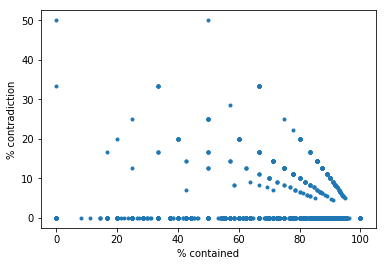

In [79]:
plt.scatter(scores[:,0], scores[:,2], marker='.')
plt.xlabel("% contained")
plt.ylabel("% contradiction")
plt.show()

# Trying BERT embeddings....

In [35]:
bert_embedding = BertEmbedding()
embed = bert_embedding(src_lines[0].split(' . '))

['relations between iran and saudi arabia have always been thorny , but rarely has the state of affairs been as venomous as it is today',
 'tehran and riyadh each point to the other as the main reason for much of the turmoil in the middle east',
 'in its most recent incarnation , the iranian-saudi conflict by proxy has reached yemen in a spiral that both sides portray as climatic',
 "for riyadh and its regional allies , the saudi military intervention in yemen -- `` operation decisive storm'' -- is the moment the sunni arab nation finally woke up to repel the expansion of shia-iranian influence",
 "for tehran and its regional allies -- including the houthi movement in yemen -- saudi arabia's actions are in defense of a retrogressive status quo order that is no longer tenable",
 'and yet both sides have good reasons to want to stop the yemeni crisis from spiraling out of control and evolving into an unwinnable war',
 'when iranian president hassan rouhani was elected in june 2013 , he p

In [51]:
embed[0][0]

['relations',
 'between',
 'iran',
 'and',
 'saudi',
 'arabia',
 'have',
 'always',
 'been',
 'thorny',
 ',',
 'but',
 'rarely',
 'has',
 'the',
 'state',
 'of',
 'affairs',
 'been',
 'as',
 'venomous']

In [54]:
# for i in range(len(embed[0][1])):
#     plt.scatter([embed[0][1][i][0]], [embed[0][1][i][1]], label=embed[0][0][i])
# # plt.scatter([embed[0][1][i][0] for i in range(len(embed[0][1]))], 
# #             [embed[0][1][i][1] for i in range(len(embed[0][1]))])
# # plt.scatter([embed[0][1][2][0]], [embed[0][1][2][1]])
# # plt.scatter([embed[0][1][4][0]], [embed[0][1][4][1]])
# # plt.scatter([embed[0][1][5][0]], [embed[0][1][5][1]])
# plt.legend()
# plt.show()

In [45]:
np.linalg.norm(embed[0][1][4] - embed[0][1][5])

10.376158

In [50]:
bert_embedding = BertEmbedding()

Vocab file is not found. Downloading.


In [63]:
i=0
with open("data/test.txt.src.tagged.shuf.400words") as src:
    with open("data/bottom_up_cnndm_015_threshold.out") as gen:
        for src_line0, gen_line0 in zip(src, gen):
            if(i >= 8):
                break
#             print(src_line0)
            i+=1

In [75]:
sentence = gen_line.split(' . ')

In [91]:
result = bert_embedding(["I ate a dog", "I ate a cat"])


In [92]:
result[0][0]

['i', 'ate', 'a', 'dog']

In [93]:
np.linalg.norm(result[1][1][3]- result[0][1][3])

6.3448873

In [94]:
np.linalg.norm(result[1][1][1]- result[0][1][1])

2.9955516